## Demo

This notebook demonstrates how to use the CartoonX code with a CNN and a simple Vision Transformer classifier. Moeover, it shows how to get the attention rollout.

Below, we will classify a picture of a stingray with MobileNet and a DeiT-tiny and explain the classification "basketball" with CartoonX (for both the CNN and the ViT) and with an attention rollout (for the ViT).

In [9]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os, sys
import cv2

import torch
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import timm

sys.path.insert(1, os.path.join(sys.path[0], '../'))
from cartoonx.cartoonX import CartoonX 

# Change direction to vit_explain
sys.path.insert(1, os.path.join(sys.path[1], 'vit-explain/'))
from vit_explain import show_mask_on_image
from vit_rollout import VITAttentionRollout

# Preprocess the image

In [10]:
# get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")                      

# get image and preprocess the image
imgdir = "../images/imagenet_sample"
fname = "n01498041_stingray.JPEG"
path = os.path.join(imgdir, fname)
x = Image.open(path)
x = transforms.ToTensor()(x)
x = transforms.Resize(size=(224,224))(x)
x = x.to(device)

# CartoonX for the Vision Transformer (ViT)

In [12]:
# classifiy image with the ViT
vit_model = timm.create_model('deit_tiny_patch16_224', pretrained=True).eval().to(device)
output_vit = vit_model(x.unsqueeze(0).detach())
pred_vit = nn.Softmax(dim=1)(output_vit).max(1)[1].item() 

# set CartoonX hyperparameters for the ViT
HPARAMSVIT ={"wave": "db3", "mode": "zero", "J": 5,
          "l1lambda": 10, "step_size": 1e-3,
          "num_steps": 2001,  "batch_size": 64,
          "distortion_measure": "label"
          } 

# get Cartoon RDE for the VIT
cartoonX_vit = CartoonX(model=vit_model, device=device, **HPARAMSVIT)
explanation_vit = cartoonX_vit(x.unsqueeze(0), target=pred_vit, path=path)

 iter 0

KeyboardInterrupt: 

# CartoonX for the CNN

In [13]:
# classifiy image with the CNN
cnn_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).eval().to(device)
output_cnn = cnn_model(x.unsqueeze(0).detach())
pred_cnn = nn.Softmax(dim=1)(output_cnn).max(1)[1].item() 


# set CartoonX hyperparameters for the CNN
HPARAMSCNN ={"wave": "db3", "mode": "zero", "J": 5,
          "l1lambda": 20, "step_size": 1e-3,
          "num_steps": 2001,  "batch_size": 64,
          "distortion_measure": "label"
          } 

# get Cartoon RDE for the CNN
cartoonX_cnn = CartoonX(model=cnn_model, device=device, **HPARAMSCNN)
explanation_cnn= cartoonX_vit(x.unsqueeze(0), target=pred_cnn, path=path)

 iter 0

KeyboardInterrupt: 

# Attention rollout

In [15]:
# Get the attention maps 
rollout = VITAttentionRollout(vit_model) 
mask = rollout(x.unsqueeze(0).detach())

# Put mask on image for the attention rollout
np_img = np.asarray(transforms.ToPILImage()(x))
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
masked_img = show_mask_on_image(np_img, mask) 

# Get image in RGB
masked_img_rgb = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

# Visualization

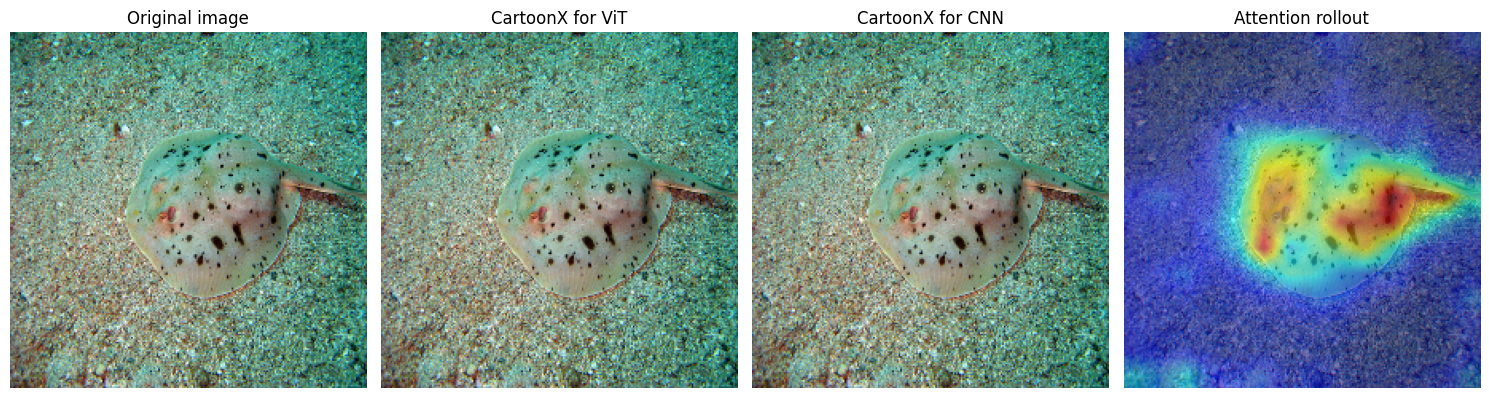

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

# Obtain the original image, the results of the CartponX for ViT and for CNN and the attention rollout
orig_im = transforms.ToPILImage()(x.cpu())
cartoon_im_vit = transforms.ToPILImage()(explanation_vit.cpu())
cartoon_im_cnn = transforms.ToPILImage()(explanation_cnn.cpu())
attention_im = masked_img_rgb

# Plot results
axs[0].set_title('Original image')
axs[0].imshow(orig_im)
axs[0].axis('off')

axs[1].set_title('CartoonX for ViT')
axs[1].imshow(cartoon_im_vit, cmap='copper')
axs[1].axis('off')

axs[2].set_title('CartoonX for CNN')
axs[2].imshow(cartoon_im_cnn, cmap='copper')
axs[2].axis('off')

axs[3].set_title('Attention rollout')
axs[3].imshow(attention_im)
axs[3].axis('off')

plt.show()